In [24]:
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch.nn as nn
import soundfile
import os

model = torch.load('/datasets/home/07/907/k1feng/ReverbNN/outputs/models/vae_16.model')
reverberator = model.synth[1]

In [9]:
print(reverberator.block_size)
print(reverberator.sequence_size)
print(reverberator.size)
print(reverberator.wetdry.size())
print(reverberator.decay.size())

80
200
16000
torch.Size([64, 1])
torch.Size([64, 1])


In [33]:
# They set batch_size default to 64, so I need to always pick the first params
def test_reverb(rvb, z):
    # Pad the input sequence
    y = nn.functional.pad(z, (0, rvb.size), "constant", 0)
    # Compute STFT
    Y_S = torch.rfft(y, 1)
    print(Y_S.size())
    # Compute the current impulse response
    idx = torch.sigmoid(rvb.wetdry[0]) * rvb.identity[0]
    imp = torch.sigmoid(1 - rvb.wetdry[0]) * rvb.impulse[0]
    dcy = torch.exp(-(torch.exp(rvb.decay[0]) + 2) * torch.linspace(0,1, rvb.size).to(z.device))
    final_impulse = idx + imp * dcy
    # Pad the impulse response
    impulse = nn.functional.pad(final_impulse, (0, rvb.size), "constant", 0)
    if y.shape[-1] > rvb.size:
        impulse = nn.functional.pad(impulse, (0, y.shape[-1] - impulse.shape[-1]), "constant", 0)
    IR_S = torch.rfft(impulse.detach(),1).expand_as(Y_S)
    # Apply the reverb
    Y_S_CONV = torch.zeros_like(IR_S)
    Y_S_CONV[:,:,0] = Y_S[:,:,0] * IR_S[:,:,0] - Y_S[:,:,1] * IR_S[:,:,1]
    Y_S_CONV[:,:,1] = Y_S[:,:,0] * IR_S[:,:,1] + Y_S[:,:,1] * IR_S[:,:,0]
    # Invert the reverberated signal
    y = torch.irfft(Y_S_CONV, 1, signal_sizes=(y.shape[-1],))
    return y

In [34]:
import soundfile

AMP = 20

audio, sr = librosa.load('./dataset/guitarset/00_BN1-129-Eb_solo_mix.wav',sr=None)

audio = torch.from_numpy(audio).float().unsqueeze(0).to('cuda:0')
# filtered = reverberator.forward((audio,None))
filtered = test_reverb(reverberator, audio).squeeze(0).cpu().numpy()
soundfile.write('/datasets/home/07/907/k1feng/ReverbNN/dataset/reverb_sound.wav', filtered* AMP, 44100)

torch.Size([1, 500254, 2])


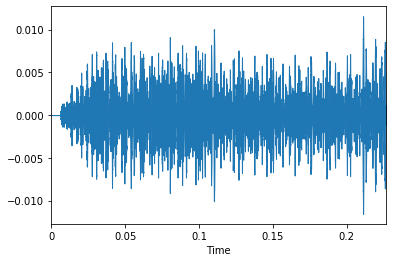

In [35]:
librosa.display.waveplot(filtered[:10000], sr=sr)
plt.show()

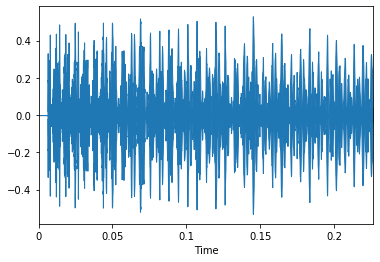

In [36]:
y, _ = librosa.load('./dataset/guitarset/00_BN1-129-Eb_solo_mix.wav',sr=None)
librosa.display.waveplot(y[:10000], sr=sr)
plt.show()